In [1]:
%pip install scikit-learn scikit-lego

  Using cached scipy-1.16.0-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.5.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached joblib-1.5.1-py3-none-any.whl (307 kB)
Using cached scipy-1.16.0-cp313-cp313-win_amd64.whl (38.4 MB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.1 MB 6.9 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.1 MB 6.7 MB/s eta 0:00:02
   -------------- ------------------------- 3.9/11.1 MB 6.6 MB/s eta 0:00:02
   ------------------ --------------------- 5.2/11.1 MB 6.8 MB/s eta 0:00:01
   ------------------------ --------------- 6.8/11.1 MB 6.8 MB/s eta 0:00:01
   ----------------------------- ---------- 8.1/11.1 MB 6.7 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/11.1 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.1 MB 6.8 MB/s eta 0:00

In [2]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification

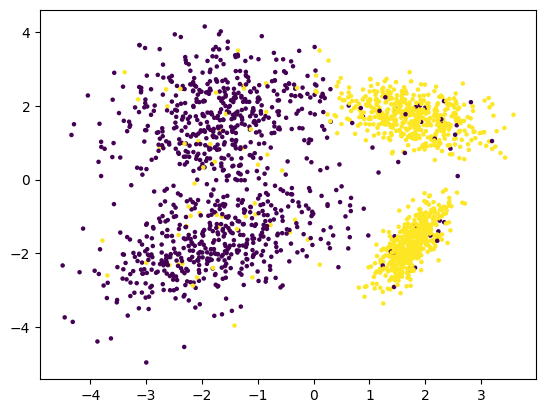

In [3]:
X, y = make_classification(n_samples=2000, n_features=2,
                           n_redundant=0, random_state=21,
                           class_sep=1.75, flip_y=0.1)
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

In [4]:
def make_plots():
    X_new = np.concatenate([
        np.random.uniform(np.min(X[:, 0]), np.max(X[:, 0]), (20000, 1)),
        np.random.uniform(np.min(X[:, 1]), np.max(X[:, 1]), (20000, 1))
    ], axis=1)
    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5)
    plt.title("original data")
    plt.subplot(142)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf1.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens1")
    plt.subplot(143)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf2.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens2")
    plt.subplot(144)
    plt.scatter(X_new[:, 0], X_new[:, 1], c=clf3.predict_proba(X_new)[:, 1], s=5)
    plt.title("ens3");

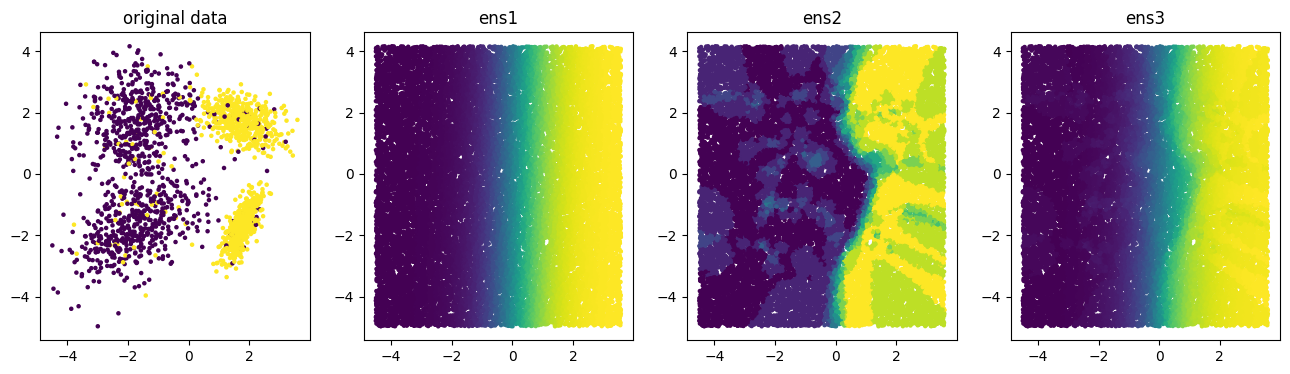

In [23]:
clf1 = LogisticRegression().fit(X, y)
clf2 = KNeighborsClassifier(n_neighbors=10).fit(X, y)
clf3 = VotingClassifier(estimators=[('clf1', clf1), ('clf2', clf2)],
                        voting='soft',
                        weights=[10, 2])
clf3.fit(X, y)

make_plots()

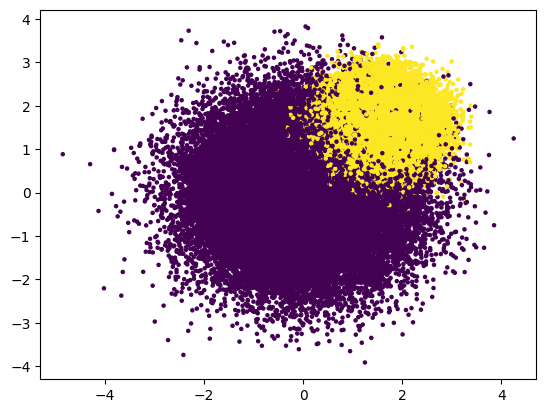

In [43]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100000, centers=[(0, 0), (1.5, 1.5)], cluster_std=[1, 0.5])
plt.scatter(X[:, 0], X[:, 1], c=y, s=5);

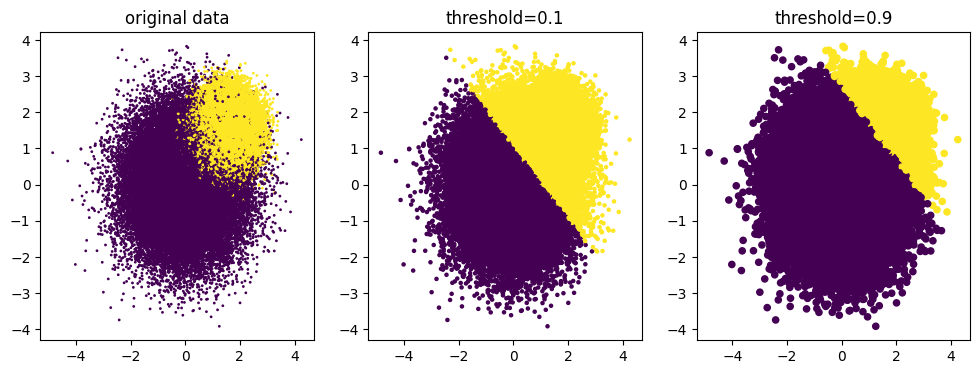

In [51]:
plt.figure(figsize=(12, 4)) #12 "width" oluyor, 4 "height" oluyor.
plt.subplot(131)#not sure what this number 131 means..?
plt.scatter(X[:, 0], X[:, 1], c=y, s=1) #s=1 yapınca noktalar daha küçük oluyor.
plt.title("original data") #Üzerine başlık ekliyoruz.
plt.subplot(132)#I don't know what this does..?
plt.scatter(X[:, 0], X[:, 1], c=m1.predict(X), s=5)
plt.title("threshold=0.1")
plt.subplot(133)#I don't know what is this..?
plt.scatter(X[:, 0], X[:, 1], c=m2.predict(X), s=20)#s=20 yapınca noktalar daha büyük oldular.
plt.title("threshold=0.9"); #Demekki noktaların büyüklüğü s'ye bağlıdır.

In [52]:
pipe = Pipeline([
    ("model", Thresholder(LogisticRegression(solver='lbfgs'), threshold=0.1))
])

mod = GridSearchCV(estimator=pipe,
                  param_grid = {"model__threshold": np.linspace(0.1, 0.9, 50)},
                  scoring={"precision": make_scorer(precision_score),
                            "recall": make_scorer(recall_score),
                            "accuracy": make_scorer(accuracy_score)},
                  refit="precision",
                  cv=5)

mod.fit(X, y);

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklego.datasets import load_chicken
from sklego.preprocessing import ColumnSelector

df = load_chicken(as_frame=True)

def plot_model(model):
    df = load_chicken(as_frame=True)
    model.fit(df[['diet', 'time']], df['weight'])
    metric_df = df[['diet', 'time', 'weight']].assign(pred=lambda d: model.predict(d[['diet', 'time']]))
    metric = mean_absolute_error(metric_df['weight'], metric_df['pred'])
    plt.figure(figsize=(12, 4))
    # plt.scatter(df['time'], df['weight'])
    for i in [1, 2, 3, 4]:
        pltr = metric_df[['time', 'diet', 'pred']].drop_duplicates().loc[lambda d: d['diet'] == i]
        plt.plot(pltr['time'], pltr['pred'], color='.rbgy'[i])
    plt.title(f"linear model per group, MAE: {np.round(metric, 2)}");

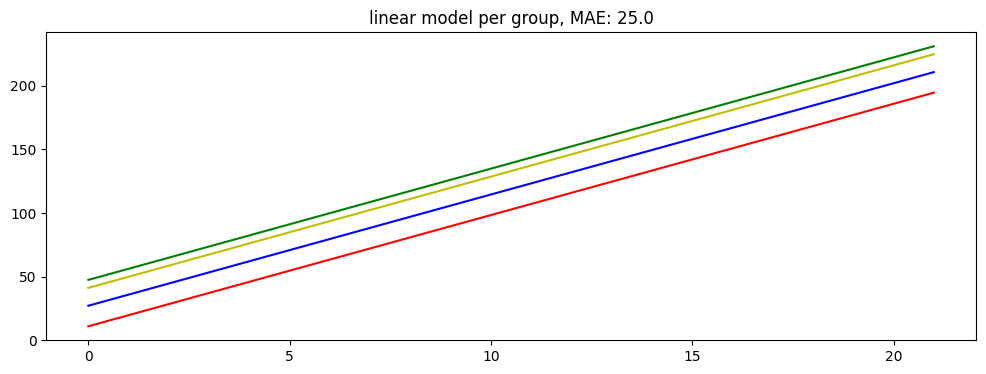

In [57]:
feature_pipeline = Pipeline([
    ("datagrab", FeatureUnion([
        ("discrete", Pipeline([
            ("grab", ColumnSelector("diet")),
            ("encode", OneHotEncoder(categories="auto"))
        ])),
        ("continuous", Pipeline([
            ("grab", ColumnSelector("time")),
            ("standardize", StandardScaler())
        ]))
    ]))
])

pipe = Pipeline([
    ("transform", feature_pipeline),
    ("model", LinearRegression())
])

plot_model(pipe)
